In [48]:
import datetime as dt
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
from sklearn import linear_model
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as multi
import h5py

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')



In [49]:
import folium
from folium import plugins

In [50]:
# set the station shapefile address
stationPointShape=r'G:\NationalLayer\ClimateData\Stations\Stations_All_USAl.shp'
field_id='StationFID'

In [51]:
# rasters
nlcd_tc_Address=r'G:\NationalLayer\NLCD_Products\2016\nlcd_2016_treecanopy_2019_08_31\nlcd_2016_treecanopy_2019_08_31_projected.img'
nlcd_lc_Address=r'G:\NationalLayer\NLCD_Products\2016\NLCD_2016_Land_Cover_L48_20190424\NLCD_2016_Land_Cover_L48_20190424_projected.img'
nlcd_imp_address=r'G:\NationalLayer\NLCD_Products\2011\nlcd_2011_impervious_2011_edition_2014_10_10\NLCD_Impervious_Projected\Impervious_Projected.img'
nlud_Address= r'G:\NationalLayer\NationalLandUse_0140326\nlud2010_Projected.img'
# set the address of air temperature layer
meainAirTempAddreess=r'G:\NationalLayer\ClimateData\Prism\meanTemp\MeanSummerProjected\meanSummer30mProjected.img'

# set the CDD and HDD rasters
cddRasterAddress=r'G:\NationalLayer\ClimateData\Prism\PRISM_tmean_stable_4kmD1_20110101_20111231_bil\CDD2011Projected30m.img'
hddRasterAddress=r'G:\NationalLayer\ClimateData\Prism\PRISM_tmean_stable_4kmD1_20110101_20111231_bil\HDD2011Projected30m.img'

# set the address of surface temp hdf file
# key is 'ST'
stAddress=r'G:\NationalLayer\ST\st_stacked.hdf5'
# set the address of ndvi hdf file
# key is 'ST'
ndviAddress=r'G:\NationalLayer\ST\ndvi_stacked.hdf'
# set the address of buiilding datasets
bldgSumAddress=r'G:\NationalLayer\US_Buildings\Conterminous_US_Building_Total_Area\bldgSum.img'
#bldgAveAddress=r'G:\tempBuildings\bldgAvgWithNull.img'
bldgCountAddress=r'G:\NationalLayer\US_Buildings\Conterminous_US_Building_Centroid_Count\bldgCountCentroid.img'

#demAddress=r'G:\NationalLayer\US_DEM_2016_02192019\US_DEM_2016_02192019\Grid\us_dem_2016_projected2.img'

#maxPreDefAddress=r'G:\NationalLayer\ClimateData\Prism\MaximumVaporPressureDeficit\AveMaxVpDmax_30mProjected.img'
#minPreDefAddress=r'G:\NationalLayer\ClimateData\Prism\MinimumVaporPressureDeficcit\AveMinVpDmin_30mProjected.img'

In [5]:
# setting the distance to search values around each station
search=1000

In [6]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [7]:
dfCSV_US= pd.read_csv(r'G:\NationalLayer\ClimateData\Stations\Stations_All_USA.csv')
dfCSV_US['StationFID']=dfCSV_US['StationFID'].astype('int')

In [8]:
# create a dictionary that keeps the coordinates of every sation point. the key is the sation_id
dicStationCoors={}
for stPoint in fiona.open(stationPointShape):
    st_id=stPoint['properties'][field_id]
    p=(shape(stPoint['geometry']))
    st_coors=(p.x,p.y)
    dicStationCoors[st_id]=st_coors

In [9]:
dfCSV_US.head()

,Station_ID,Ycoor,Xcoor,Elevation,Name,col2,col3,col4,col5,col6,col7,col8,col9,col10,StationFID
0,CA001018611,48.0333,-123.3333,70.0,BC,VICTORIA,GONZALES,CS,71200,0,NaN,NaN,NaN,NaN,1
1,CA001102420,49.0000,-123.0833,51.0,BC,DELTA,PEBBLE,HILL,NaN,0,NaN,NaN,NaN,NaN,2
2,CA001103635,49.0000,-122.2167,8.0,BC,HUNTINGDON,METER,STATION,NaN,0,NaN,NaN,NaN,NaN,3
3,CA001135126,49.0000,-118.7667,580.0,BC,MIDWAY,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,4
4,CA001144230,49.0000,-116.1833,820.0,BC,KINGSGATE,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,5


In [10]:
year=2016
# set the columns of the csv file here
colNames=["ST_ID_CDC", "Date", "Type", "Reading","Measurement_Flag","Quality_Flag","Source_Flag","col99"]
# set the csv of the climate file
dfAllVars=pd.read_csv(r'G:\NationalLayer\ClimateData\Raw_CDC_data\2016csv\{}.csv'.format(year),names=colNames)

In [11]:
dfAllVars.head()

,ST_ID_CDC,Date,Type,Reading,Measurement_Flag,Quality_Flag,Source_Flag,col99
0,US1FLSL0019,20160101,PRCP,3,NaN,NaN,N,NaN
1,NOE00133566,20160101,TMAX,95,NaN,NaN,E,NaN
2,NOE00133566,20160101,TMIN,23,NaN,NaN,E,NaN
3,NOE00133566,20160101,PRCP,10,NaN,NaN,E,NaN
4,USC00141761,20160101,TMAX,22,NaN,NaN,7,700.0


In [12]:
dfAllVars['Date']=pd.to_datetime(dfAllVars['Date'], format='%Y%m%d')

In [13]:
# seting the start and end of the summer season
start_date=pd.to_datetime('{}0615'.format('2016'),format='%Y%m%d')
end_date=pd.to_datetime('{}0815'.format('2016'),format='%Y%m%d')

In [14]:
# set the summer col and assign the value of 1 to summer records
dfAllVars['summer']=0
dfAllVars.loc[(dfAllVars['Date'] >= start_date)&(dfAllVars['Date'] <= end_date), 'summer'] = 1

In [15]:
# create a df for summer only records
dfAllVarsSummer=dfAllVars.loc[(dfAllVars['summer']==1)]

In [16]:
dfAllVarsSummer.head()

,ST_ID_CDC,Date,Type,Reading,Measurement_Flag,Quality_Flag,Source_Flag,col99,summer
16134775,US1FLSL0019,2016-06-15,PRCP,0,NaN,NaN,N,NaN,1
16134776,US1FLSL0019,2016-06-15,SNOW,0,NaN,NaN,N,NaN,1
16134777,NOE00133566,2016-06-15,TMAX,169,NaN,NaN,E,NaN,1
16134778,NOE00133566,2016-06-15,TMIN,42,NaN,NaN,E,NaN,1
16134779,NOE00133566,2016-06-15,PRCP,0,NaN,NaN,E,NaN,1


In [17]:
dfAllVarsSummer[dfAllVarsSummer['Type']=='EVAP']

,ST_ID_CDC,Date,Type,Reading,Measurement_Flag,Quality_Flag,Source_Flag,col99,summer
16134799,RQC00660061,2016-06-15,EVAP,38,NaN,NaN,7,800.0,1
16134979,USC00169074,2016-06-15,EVAP,38,NaN,NaN,7,800.0,1
16135197,USC00049026,2016-06-15,EVAP,51,NaN,NaN,7,800.0,1
16135675,USC00143527,2016-06-15,EVAP,99,NaN,NaN,7,800.0,1
16136086,USC00415661,2016-06-15,EVAP,102,NaN,NaN,7,700.0,1
...,...,...,...,...,...,...,...,...,...
22051390,USC00355734,2016-08-15,EVAP,178,NaN,NaN,7,800.0,1
22051981,USC00391076,2016-08-15,EVAP,56,NaN,NaN,7,800.0,1
22051997,USC00410784,2016-08-15,EVAP,328,NaN,NaN,7,NaN,1
22052066,USC00412225,2016-08-15,EVAP,1069,NaN,NaN,7,800.0,1


In [19]:
# creating separate dfs for each type of climate data using their flags
dfTempAve0      =dfAllVarsSummer[dfAllVarsSummer['Type']=='TAVG']
dfTempMin0      =dfAllVarsSummer[dfAllVarsSummer['Type']=='TMIN']
dfTempMax0      =dfAllVarsSummer[dfAllVarsSummer['Type']=='TMAX']
dfWindDirection0=dfAllVarsSummer[dfAllVarsSummer['Type']=='WDF5']
dfAveWindSpeed0 =dfAllVarsSummer[dfAllVarsSummer['Type']=='AWND']
dfPrecip0       =dfAllVarsSummer[dfAllVarsSummer['Type']=='PRCP']
dfEvaporation0  =dfAllVarsSummer[dfAllVarsSummer['Type']=='EVAP']

In [20]:
# dfTempAve
dfTempAve=dfTempAve0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfTempAve['ST_ID_CDC']=dfTempAve.index
dfTempAve=dfTempAve[dfTempAve['StationFID']>0]
# dfTempMin
dfTempMin=dfTempMin0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfTempMin['ST_ID_CDC']=dfTempMin.index
dfTempMin=dfTempMin[dfTempMin['StationFID']>0]
# dfTempMax
dfTempMax=dfTempMax0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfTempMax['ST_ID_CDC']=dfTempMax.index
dfTempMax=dfTempMax[dfTempMax['StationFID']>0]
# dfWind Direction
dfTempWindDirection=dfWindDirection0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfTempWindDirection['ST_ID_CDC']=dfTempWindDirection.index
dfTempWindDirection=dfTempWindDirection[dfTempWindDirection['StationFID']>0]
# dfWind Speed
dfAveWindSpeed=dfAveWindSpeed0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfAveWindSpeed['ST_ID_CDC']=dfAveWindSpeed.index
dfAveWindSpeed=dfAveWindSpeed[dfAveWindSpeed['StationFID']>0]
# dfPrcip
dfPrecip=dfPrecip0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfPrecip['ST_ID_CDC']=dfPrecip.index
dfPrecip=dfPrecip[dfPrecip['StationFID']>0]
# dfEvaporation
dfEvaporation=dfEvaporation0.set_index('ST_ID_CDC').join(dfCSV_US.set_index('Station_ID'))
dfEvaporation['ST_ID_CDC']=dfEvaporation.index
dfEvaporation=dfEvaporation[dfEvaporation['StationFID']>0]

In [22]:
dictWindDir={}
# for limits in lstMap:
for l in list(range(0, 361, 1)):
    if l>=0 and l<45:
        dictWindDir[l]='N'
    elif l>=45 and l<135:
        dictWindDir[l]='E'
    elif l>=135 and l<225:
        dictWindDir[l]='S'
    elif l>=225 and l<315:
        dictWindDir[l]='W'
    elif l>=315 and l<=360:
        dictWindDir[l]='N'
def assignWindDir (x):
    try:
        return dictWindDir[int(x)]
    except:
        pass

In [23]:
# cleaning up the df and aggragating to get the average of temp of the season for each station
dfTempMaxFlatt=dfTempMax.groupby(['StationFID']).agg({'Reading': ['mean']})
dfTempMaxFlatt['StationFID']=dfTempMaxFlatt.index
dfTempMaxFlatt.columns = dfTempMaxFlatt.columns.droplevel(1)
dfTempMaxFlatt['TempMax']=dfTempMaxFlatt['Reading']/10
dfTempMaxFlatt.drop('Reading', axis=1, inplace=True)

In [24]:
dfTempMinFlatt=dfTempMin.groupby(['StationFID']).agg({'Reading': ['mean']})
dfTempMinFlatt['StationFID']=dfTempMinFlatt.index
dfTempMinFlatt.columns = dfTempMinFlatt.columns.droplevel(1)
dfTempMinFlatt['TempMin']=dfTempMinFlatt['Reading']/10
dfTempMinFlatt.drop('Reading', axis=1, inplace=True)

In [25]:
dfPrecipFlatt=dfPrecip.groupby(['StationFID']).agg({'Reading': ['sum']})
dfPrecipFlatt['StationFID']=dfPrecipFlatt.index
dfPrecipFlatt.columns = dfPrecipFlatt.columns.droplevel(1)
dfPrecipFlatt['Precip']=dfPrecipFlatt['Reading']/10
dfPrecipFlatt.drop('Reading', axis=1, inplace=True)

In [26]:
dfTempWindDirection['windDirectionLetter']=dfTempWindDirection.Reading.apply(assignWindDir)
dfWindDirFlatt=pd.DataFrame(dfTempWindDirection.groupby(['StationFID'])['windDirectionLetter'].agg(pd.Series.mode))
dfWindDirFlatt['StationFID']=dfWindDirFlatt.index

In [27]:
dfAveWindSpeedFlatt=dfAveWindSpeed.groupby(['StationFID']).agg({'Reading': ['mean']})
dfAveWindSpeedFlatt['StationFID']=dfAveWindSpeedFlatt.index
dfAveWindSpeedFlatt.columns = dfAveWindSpeedFlatt.columns.droplevel(1)
dfAveWindSpeedFlatt['windSpped_Ave']=dfAveWindSpeedFlatt['Reading']
dfAveWindSpeedFlatt.drop('Reading', axis=1, inplace=True)

In [28]:
dfEvaporationFlatt=dfEvaporation.groupby(['StationFID']).agg({'Reading': ['mean']})
dfEvaporationFlatt['StationFID']=dfEvaporationFlatt.index
dfEvaporationFlatt.columns = dfEvaporationFlatt.columns.droplevel(1)
dfEvaporationFlatt['evaporation']=dfEvaporationFlatt['Reading']
dfEvaporationFlatt.drop('Reading', axis=1, inplace=True)

In [29]:
dfTemp=dfTempMinFlatt.set_index('StationFID').join(dfTempMaxFlatt.set_index('StationFID'))
dfTemp['StationFID']=(dfTemp.index)

dfTemp=dfTemp.set_index('StationFID').join(dfPrecipFlatt.set_index('StationFID'))
dfTemp['StationFID']=(dfTemp.index).astype('int')

dfTemp=dfTemp.set_index('StationFID').join(dfWindDirFlatt.set_index('StationFID'))
dfTemp['StationFID']=(dfTemp.index).astype('int')

dfTemp=dfTemp.set_index('StationFID').join(dfAveWindSpeedFlatt.set_index('StationFID'))
dfTemp['StationFID']=(dfTemp.index).astype('int')

dfTemp=dfTemp.set_index('StationFID').join(dfEvaporationFlatt.set_index('StationFID'))
dfTemp['StationFID']=(dfTemp.index).astype('int')

dfTemp=dfTemp.set_index('StationFID').join(dfCSV_US.set_index('StationFID'))
dfTemp['StationFID']=(dfTemp.index).astype('int')

In [30]:
dfTemp.head(5)

,TempMin,TempMax,Precip,windDirectionLetter,windSpped_Ave,evaporation,Station_ID,Ycoor,Xcoor,Elevation,...,col2,col3,col4,col5,col6,col7,col8,col9,col10,StationFID
StationFID,,,,,,,,,,,,,,,,,,,,,
1,11.908065,20.087097,24.8,NaN,NaN,NaN,CA001018611,48.0333,-123.3333,70.0,...,VICTORIA,GONZALES,CS,71200,0,NaN,NaN,NaN,NaN,1
4,8.862903,27.153226,92.2,NaN,NaN,NaN,CA001135126,49.0000,-118.7667,580.0,...,MIDWAY,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,4
7,13.801613,25.203226,238.9,NaN,NaN,NaN,CA005020881,49.0000,-97.2333,242.0,...,EMERSON,AUTO,71560,NaN,0,NaN,NaN,NaN,NaN,7
9,13.064516,25.258065,171.0,NaN,NaN,NaN,CA006020559,48.6333,-93.9667,335.0,...,BARWICK,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,9
33232,20.615217,32.271739,224.0,NaN,NaN,NaN,USC00010063,34.2553,-87.1814,249.3,...,ADDISON,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,33232


In [31]:
dfTemp[['StationFID','Station_ID','TempMin','TempMax','Precip','windDirectionLetter','windSpped_Ave','Elevation','evaporation']]

,StationFID,Station_ID,TempMin,TempMax,Precip,windDirectionLetter,windSpped_Ave,Elevation,evaporation
StationFID,,,,,,,,,
1,1,CA001018611,11.908065,20.087097,24.8,NaN,NaN,70.0,NaN
4,4,CA001135126,8.862903,27.153226,92.2,NaN,NaN,580.0,NaN
7,7,CA005020881,13.801613,25.203226,238.9,NaN,NaN,242.0,NaN
9,9,CA006020559,13.064516,25.258065,171.0,NaN,NaN,335.0,NaN
33232,33232,USC00010063,20.615217,32.271739,224.0,NaN,NaN,249.3,NaN
...,...,...,...,...,...,...,...,...,...
58113,58113,USW00094992,11.587097,21.222581,172.0,N,22.225806,185.9,NaN
58114,58114,USW00094993,14.585484,28.419355,198.3,"[N, S]",39.258065,353.9,NaN
58115,58115,USW00094994,16.570968,29.388710,278.2,W,16.419355,204.8,NaN


In [33]:
dfTemp[dfTemp.evaporation>=0]

,TempMin,TempMax,Precip,windDirectionLetter,windSpped_Ave,evaporation,Station_ID,Ycoor,Xcoor,Elevation,...,col2,col3,col4,col5,col6,col7,col8,col9,col10,StationFID
StationFID,,,,,,,,,,,,,,,,,,,,,
33341,21.927419,33.001613,345.4,NaN,NaN,55.525424,USC00012813,30.5467,-87.8808,7.0,...,FAIRHOPE,2,NE,HCN,0,NaN,NaN,NaN,NaN,33341
33381,22.186047,33.672093,203.3,NaN,NaN,80.976744,USC00013761,31.3625,-85.3397,112.8,...,HEADLAND,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,33381
33531,20.258333,32.714894,195.5,NaN,NaN,578.777778,USC00018209,32.9206,-86.6708,207.3,...,THORSBY,EXP,STN,NaN,0,NaN,NaN,NaN,NaN,33531
33903,25.683333,40.203390,48.8,NaN,NaN,118.816667,USC00027281,33.6731,-111.1508,672.1,...,ROOSEVELT,1,WNW,HCN,0,NaN,NaN,NaN,NaN,33903
33988,24.543103,41.184906,44.7,NaN,NaN,102.568966,USC00028499,33.4258,-111.9217,355.7,...,TEMPE,ASU,NaN,NaN,0,NaN,NaN,NaN,NaN,33988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53157,10.559677,30.138710,39.4,NaN,NaN,75.865385,USC00459200,46.0436,-118.4628,192.6,...,WHITMAN,MISSION,NaN,NaN,0,NaN,NaN,NaN,NaN,53157
53488,18.054839,29.814516,333.0,NaN,NaN,0.000000,USC00468522,39.0047,-80.4739,318.5,...,STONEWALL,JACKSON,DAM,NaN,0,NaN,NaN,NaN,NaN,53488
54279,11.648387,29.983871,13.7,NaN,NaN,138.552632,USC00487388,44.7764,-108.7592,1332.6,...,POWELL,FLD,STN,HCN,0,NaN,NaN,NaN,NaN,54279


In [34]:
# transfer the projected coordinates to the dataframe
lstStationFid = list(dfTemp['StationFID'])
lstCoors = []
for item in lstStationFid:
    lstCoors.append(dicStationCoors[item])
dfTemp['XYcoorM']=lstCoors

In [35]:
def mapDataFrame(dfArg,xColArg,yColArg,labelColArg):
    locations = dfArg[[yColArg, xColArg]]
    labels=     dfArg[[labelColArg]]
    locationlist = locations.values.tolist()
    lstLables = labels.values.tolist()
    map = folium.Map(location=[38.9, -100.05], zoom_start=4.45)
    for point in range(0, len(locationlist)):
        folium.Marker(locationlist[point], popup=lstLables[point]).add_to(map)
    return map

In [36]:
len(dfTemp.TempMax)

7645

In [38]:
dfTest=dfTemp[pd.notna(dfTemp[['evaporation']])['evaporation']]
mapDataFrame(dfTest,'Xcoor','Ycoor','evaporation')

In [47]:
dfTest=dfTemp[pd.notna(dfTemp[['windSpped_Ave']])['windSpped_Ave']]
len(dfTest.windDirectionLetter)
mapDataFrame(dfTest,'Xcoor','Ycoor','windSpped_Ave')

In [39]:
with rasterio.open(nlcd_tc_Address) as rst_nlcd_tc:
            kwds = rst_nlcd_tc.meta.copy()
            mainRasterBnd=rst_nlcd_tc.bounds
            cellSize= kwds['transform'][0]

In [40]:
lstTC=[]
lstWater =[]
lstBarren=[]
lstImp =[]
lstST  =[]
lstBldgSum=[]

for p in lstCoors:
    try:
        searchBound=(p[0]-search,p[1]-search,p[0]+search,p[1]+search)
        # create a window parameter tuple.   
        winProcessing=findWindow(searchBound,mainRasterBnd,cellSize)
        #(row_start, row_stop), (col_start, col_stop)
        window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

        # read the windown in each raster and get the values

        with rasterio.open(nlcd_tc_Address) as rst_nlcd_tc:
            nlcd_tc_win_ar=rst_nlcd_tc.read(1, window=window_use)
            #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
            kwds = rst_nlcd_tc.meta.copy()
            # we calculate the area of nlcd-tc. each cell is percentage and multiplying them by 9 will return square meter.
            nlcd_tc_win_ar=nlcd_tc_win_ar*9
            tcSum=np.nansum(nlcd_tc_win_ar)
            lstTC.append(tcSum)

        #print ('got the nlcd-tc layer')

        with rasterio.open(nlcd_lc_Address) as src:
            # nlcd cells are 900m2. number of cells X area
            nlcd_lc=src.read(1, window=window_use)
            water=(np.count_nonzero(nlcd_lc == 11))*900
            barenLand=(np.count_nonzero(nlcd_lc==31))*900
            lstWater.append(water)
            lstBarren.append(barenLand)

        #print('got the nlcd-lc layer')

        with rasterio.open(nlcd_imp_address) as src:
            nlcd_imp=src.read(1, window=window_use)
            # we calculate the area of nlcd-imp. each cell is percentage and multiplying them by 9 will return square meter.
            nlcd_imp=nlcd_imp*9
            impSum=np.nansum(nlcd_imp)
            lstImp.append(impSum)

        with rasterio.open(stAddress) as src:
            sTemp=src.read(1, window=window_use)
            # the orginal temperature data is multiplied by 100 to have an integer data type. So we need to divide it by 100 here.
            sTemp=(sTemp.astype('float64'))/100
            stMean=np.nanmean(sTemp)
            lstST.append(stMean) 

        with rasterio.open(bldgSumAddress) as src:
            bldgSum=src.read(1, window=window_use)
            # the data is building area in each cell 0<area<900m2
            bldgSum=(bldgSum.astype('float64'))
            sumAllBldg=np.nansum(bldgSum)
            lstBldgSum.append(sumAllBldg)
    except:
        pass

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [41]:
dfTemp['tc'] = lstTC
dfTemp['water'] = lstWater
dfTemp['imp'] = lstImp
dfTemp['barren']=lstBarren
dfTemp['st'] = lstST
dfTemp['bldgSum'] =lstBldgSum

In [42]:
areaOfSearch = (nlcd_tc_win_ar.shape[0]*nlcd_tc_win_ar.shape[1])*900/100

In [43]:
dfTemp['tc']=dfTemp['tc']/areaOfSearch
dfTemp['imp']=dfTemp['imp']/areaOfSearch
dfTemp['bldgSum']=dfTemp['bldgSum']/areaOfSearch
dfTemp['water'] = (dfTemp['water'] / areaOfSearch)
dfTemp['barren'] = (dfTemp['barren']/areaOfSearch)

In [44]:
dfTempClean=dfTemp.loc[(dfTemp.tc>=0)&(dfTemp.bldgSum>=0)&(dfTemp.imp>=0)&
                       (dfTemp.water>=0)&(dfTemp.barren>=0)&(dfTemp.TempMax>=0)&
                       (dfTemp.TempMin>=0)&(dfTemp.Elevation>=0)&(dfTemp.Precip>=0)]

In [45]:
dfTempClean.to_csv(r'G:\NationalLayer\ClimateData\DailySummary\StationNeighborhood2016.csv')

## Decision Tree Regression

In [44]:
train, test = train_test_split(dfTempClean,test_size=0.15)
# features=['Elevation','tc','Precip','water','barren','imp','st','bldgSum','maxPrDf','Ycoor']
features=['Elevation','tc','Precip','water','barren','imp','st','bldgSum']


# define the train dataset
x_train = train[features]
#x_train.fillna(x_train.mean(), inplace=True)
y_train = train['TempMax']
# define the test dataset
x_test = test[features]
y_test = test['TempMax']
regressor = tree.DecisionTreeRegressor(random_state = 200,max_depth = 200, min_samples_split=20)
# run the regression

regressor.fit(x_train, y_train)
# y_predict=regressor.predict(df[features])
# df['y_predicted'] =y_predict

# Return the feature importances
f=regressor.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2=regressor.score(x_test, y_test)
#df['regressionR2'] =r2
# printing the results of the regression
print ('R^2 of the prediction is {0}'.format(r2))
for i in range(0,len(f)):
    print ('The importance of ', features[i],'-------',round(f[i],3))
# df['TC2']=0
# features=['TC2','ImpNotBldg','bldgSum','bldgCount','bldgAve', 'water','elevation']
# y_predict2=regressor.predict(df[features])
# df['y_predicted_0TC'] =y_predict2

R^2 of the prediction is 0.6365745046290745
The importance of  Elevation ------- 0.218
The importance of  tc ------- 0.07
The importance of  Precip ------- 0.066
The importance of  water ------- 0.012
The importance of  barren ------- 0.014
The importance of  imp ------- 0.037
The importance of  st ------- 0.245
The importance of  bldgSum ------- 0.339


In [45]:
lstR2=[]
lstError=[]
lstAbsError=[]
for i in range (0,20):
    train, test = train_test_split(dfTempClean,test_size=0.2)
    # features=['Elevation','tc','Precip','water','barren','imp','st','bldgSum','maxPrDf','Ycoor']
    features=['Elevation','tc','Precip','water','barren','imp','st','bldgSum']

    # define the train dataset
    x_train = train[features];
    x_train.fillna(x_train.mean(), inplace=True)
    y_train = train['TempMax'];
    # define the test dataset
    x_test = test[features];
    y_test = test['TempMax'];
    regressor = tree.DecisionTreeRegressor(random_state = 200,max_depth = 200, min_samples_split=20)
    # run the regression

    regressor.fit(x_train, y_train)
    y_predict=regressor.predict(dfTempClean[features])
    # df['y_predicted'] =y_predict
    modelError=y_predict-dfTempClean['TempMax'];
    lstError.append(modelError)
    lstAbsError.append(abs(modelError))
    # Return the feature importances
    f=regressor.feature_importances_

    # Returns the coefficient of determination R^2 of the prediction.
    r2=regressor.score(x_test, y_test)
    lstR2.append(r2)
    #df['regressionR2'] =r2
    # printing the results of the regression
#     print ('R^2 of the prediction is {0}'.format(r2))
#     for i in range(0,len(f)):
#         print ('The importance of ', features[i],'-------',round(f[i],3))
    # df['TC2']=0
    # features=['TC2','ImpNotBldg','bldgSum','bldgCount','bldgAve', 'water','elevation']
    # y_predict2=regressor.predict(df[features])
    # df['y_predicted_0TC'] =y_predict2

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

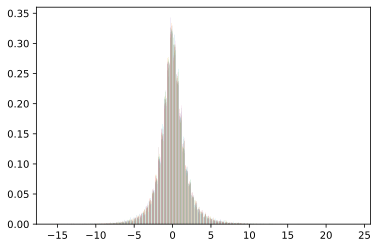

In [46]:
plt.hist(lstError,bins=100, alpha=0.9, density=True)
plt.show()

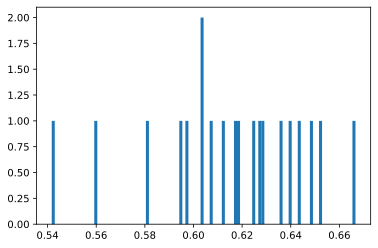

In [47]:
plt.hist(lstR2,bins=100)
plt.show()

In [48]:
print(np.mean(lstAbsError))
print(np.mean(lstR2))

1.3388987433826152
0.6151652831726625


## random forest model

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.datasets import make_regression

train, test = train_test_split(dfTempClean,test_size=0.2)
# features=['Elevation','tc','Precip','water','barren','imp','st','bldgSum','maxPrDf','Ycoor']
features=['Elevation','tc','water','barren','imp','st','bldgSum']

# define the train dataset
x_train = train[features]
x_train.fillna(x_train.mean(), inplace=True)
y_train = train['TempMax']
# define the test dataset
x_test = test[features]
y_test = test['TempMax']

# instanciate the regressor object
regressor = ExtraTreesRegressor(n_estimators=10000,min_samples_split=50,max_depth=200,
                                  random_state=0
                                )
# run the regression
regressor.fit(x_train, y_train)
y_predict=regressor.predict(dfTempClean[features])
error=(np.abs(y_predict-dfTempClean['TempMax'])).mean()
print ('the model error is {}'.format(error))
# Return the feature importances
f=regressor.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2=regressor.score(x_test, y_test)

print('the model summary is {}'.format(r2))

# printing the results of the regression
print ('R^2 of the prediction is {0}'.format(r2))
for i in range(0,len(f)):
    print ('The importance of ', features[i],'-------',round(f[i],3))

C:\ProgramData\Anaconda2\envs\myenv\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


the model error is 1.7656510995865524
the model summary is 0.7214317683475046
R^2 of the prediction is 0.7214317683475046
The importance of  Elevation ------- 0.437
The importance of  tc ------- 0.19
The importance of  water ------- 0.01
The importance of  barren ------- 0.021
The importance of  imp ------- 0.033
The importance of  st ------- 0.285
The importance of  bldgSum ------- 0.025
